In [4]:
!pip install langdetect
!pip install transformers
!pip install simpletransformers
#!pip install EmailParser

import re
import nltk
import spacy
import string

import numpy as np
import random as r
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from transformers import *
from langdetect import detect
from langdetect import DetectorFactory
from simpletransformers.classification import ClassificationModel

nlp = spacy.blank("de")

## Definition of functions

### Preprocessing functions

In [176]:
def grouping(tuple_list, threshold, new_label, save_set):
  grouped_value = 0
  new_list = []
  for tup in tuple_list:
    if tup[1] < threshold and tup[1] not in save_set:
      grouped_value += tup[1]
    else:
      new_list.append(tup)
  new_list.append((new_label, grouped_value))
  return new_list

In [177]:
def df_relabel(dataframe, column, label_group):
  for index in range(len(dataframe)):
    if not dataframe.iloc[index][column] in (label_group):
      dataframe.iloc[index][column] = "EDA_others"

In [178]:
def AvgMedianLen(x):
  df = {}
  df['mean_character_count'] = x['MailTextBody'].str.len().mean()
  df['mean_word_count'] = x['MailTextBody'].str.split().str.len().mean()
  return pd.Series(df, index=['mean_character_count', 'mean_word_count'])

In [179]:
def identify_language(document):
    return detect(document.lower())

In [180]:
# Plot label distribution of the data.
def plot_label_distribution(df, label_name, threshold=False):
  """Input: Dataframe, threshold for filtering label frequency.Output: Plotting of label distribution of dataset.""" 
  label_count_dic = df[label_name].value_counts().to_dict()
  label_list = [] # going to be x-axis
  label_freq_list = [] # going to be y-axis
  
  for label, freq in zip(label_count_dic.keys(), label_count_dic.values()):
    # If threshold applies, filter values above threshold.
    if threshold != False: 
      if freq < threshold:
        label_list.append((label))
        label_freq_list.append((freq))
    else:
        label_list.append(label)
        label_freq_list.append((freq))
  # Plotting the distribution.
  plt.figure(figsize=(20,10))
  plt.xticks(rotation="vertical", fontsize=10)
  plt.title("Distribution of All Labels") if threshold == False else plt.title("Label Distribution with Thresholded Labels Frequencies")
  plt.bar(label_list, label_freq_list)
  return plt.show()

### Opening of train.cvs and test_reduced.csv

In [184]:
train = pd.read_csv("data/train.csv", sep=";")

In [185]:
test = pd.read_csv("data/test_reduced.csv", sep=";")

In [186]:
train = train[["Id", "Urgency", "IncidentType", "MailSubject", "MailTextBody", "ServiceProcessed"]]

### Exploratory Data Analysis

#### Pie chart of urgency data

In [187]:
train["Urgency"].value_counts()

4-Low         2320
3-Medium       410
2-High         111
1-Critical       4
Name: Urgency, dtype: int64

([<matplotlib.patches.Wedge at 0x7fba957c82b0>,
 [Text(-0.9202707710716971, 0.6025792129762727, '4-Low'),
  Text(0.8365452582684422, -0.7142772787010556, '3-Medium'),
  Text(1.0905165623684114, -0.14413059078551962, '2-High'),
  Text(1.0999892703253211, -0.004858515119625025, '1-Critical')])

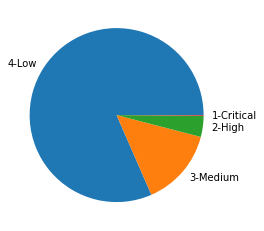

In [188]:
plt.pie(train["Urgency"].value_counts(), labels=train["Urgency"].value_counts().keys() )

#### Plot of the occurrences of ServiceProcessed elements
The class imbalance is uncanny and several graphs show it.

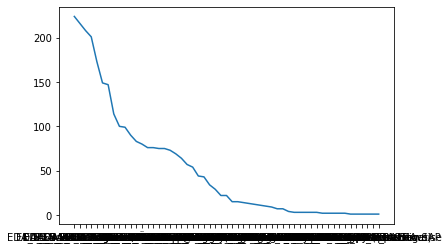

In [189]:
plt.plot(train["ServiceProcessed"].value_counts())

In [190]:
(train["ServiceProcessed"].value_counts()).sort_index()

EDA_ANW_ARIS (EDA Scout)                  1
EDA_ANW_ARS Remedy                       13
EDA_ANW_CH@World (MOSS)                  57
EDA_ANW_CodX PostOffice                   1
EDA_ANW_DMS Fabasoft eGov Suite          15
EDA_ANW_EDA PWC Tool                      2
EDA_ANW_EDAContacts                       2
EDA_ANW_EDAssist+                         2
EDA_ANW_FDFA Security App                 3
EDA_ANW_IAM Tool EDA                      3
EDA_ANW_ITDoc Sharepoint                  3
EDA_ANW_Internet EDA                     10
EDA_ANW_Intranet/Collaboration EDA       90
EDA_ANW_MOVE!                            11
EDA_ANW_NOS:4                             2
EDA_ANW_ORBIS                             2
EDA_ANW_Office Manager                    3
EDA_ANW_Plato-HH                          7
EDA_ANW_Reisehinweise                     1
EDA_ANW_SAP Services                     75
EDA_ANW_SysP eDoc                       173
EDA_ANW_ZACWEB                           43
EDA_ANW_Zeiterfassung SAP       

In [191]:
train_dict = [(key, value) for key,value in train["ServiceProcessed"].value_counts().to_dict().items()]

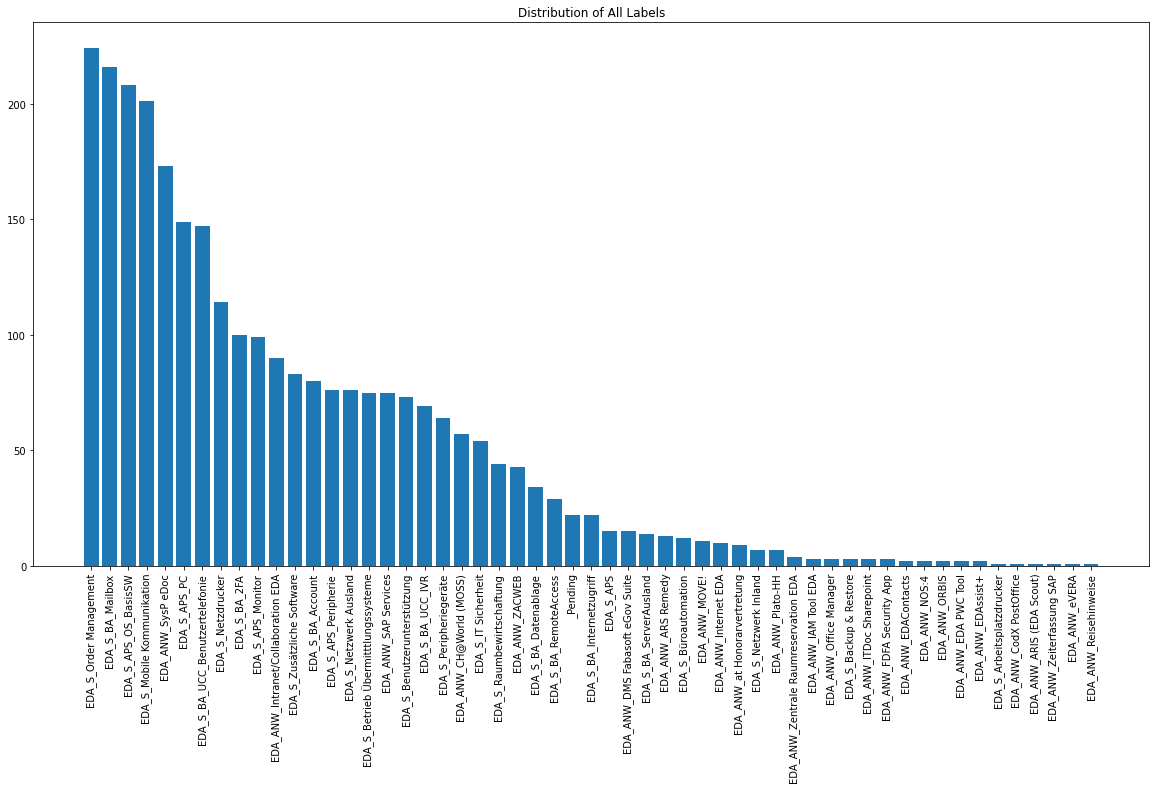

In [192]:
plot_label_distribution(train, "ServiceProcessed", threshold=False)

#### Computing mean characters and mean word count per label
The more metrics we collect the merrier we are!

In [193]:
df_uncleaned = train.groupby(by="ServiceProcessed").apply(AvgMedianLen)

In [194]:
df_uncleaned

,mean_character_count,mean_word_count
ServiceProcessed,,
EDA_ANW_ARIS (EDA Scout),470.000000,68.000000
EDA_ANW_ARS Remedy,366.230769,54.692308
EDA_ANW_CH@World (MOSS),413.122807,60.280702
EDA_ANW_CodX PostOffice,1461.000000,169.000000
EDA_ANW_DMS Fabasoft eGov Suite,398.933333,60.600000
EDA_ANW_EDA PWC Tool,389.000000,58.000000
EDA_ANW_EDAContacts,391.500000,55.500000
EDA_ANW_EDAssist+,1134.000000,162.000000
EDA_ANW_FDFA Security App,496.000000,70.333333


## Data cleaning section

### Merging MailSubject and MailTextBody
This is done for both the train and test dataset

In [195]:
train["WholeMail"] = train["MailSubject"] + " " + train["MailTextBody"]

In [196]:
test["WholeMail"] = test["MailSubject"] + " " + test["MailTextBody"]

#### Cleaning of the train dataset

In [197]:
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
new_text = {"texts":[], "services":[]}
s = 0
for index in range(len(train)):
  email = str(train.iloc[index]["WholeMail"])
  phrase = []
  for word in str(email).split():
    if ("MD5" not in word) and ("www" not in word) and ("FW:" not in word) and ("[cid:i" not in word) :
      phrase.append(word.lower())
  email = " ".join(phrase)
  email = re.sub(pattern, "", email)
  tokenized_sentence = " ".join([token.text for token in nlp(email)])
  if len(tokenized_sentence)>10000:
    print(len(tokenized_sentence))
    continue
  if identify_language(tokenized_sentence ) == "de":
    new_text["texts"].append(tokenized_sentence)
    new_text["services"].append(str(train.iloc[index]["ServiceProcessed"]))
print(len(new_text["texts"]), len(new_text["services"]))

31703
14837
24084
25680
23994
10495
12912
2666 2666


In [198]:
train = pd.DataFrame.from_dict(new_text)

#### Cleaning of the test dataset
No rows get removed, everything is good to make tomato sauce.

In [199]:
new_text = {"Id":[], "texts":[]}
s = 0
for index in tqdm(range(len(test))):
  email = str(test.iloc[index]["WholeMail"])
  id = str(test.iloc[index]["Id"])
  phrase = []
  for word in str(email).split():
    if ("MD5" not in word) and ("www" not in word) and ("FW:" not in word) and ("[cid:i" not in word) :
      phrase.append(word.lower())
  email = " ".join(phrase)
  email = re.sub(pattern, "", email)
  tokenized_sentence = " ".join([token.text for token in nlp(email)])
  #if identify_language(tokenized_sentence ) == "de":
  new_text["texts"].append(tokenized_sentence)
  new_text["Id"].append(id)
    #new_text["services"].append(str(test.iloc[index]["ServiceProcessed"]))
print(len(new_text["texts"]))

100%|██████████| 712/712 [00:00<00:00, 991.23it/s]

712


In [200]:
test = pd.DataFrame.from_dict(new_text)

In [201]:
len(test)

712

### Encoding of classes into numbers

In [202]:
train.head()

,texts,services
0,smart card blockiert lieber helpdesk sie haben...,EDA_S_BA_2FA
1,webcam liebe kolleginnen und kollegen ich möch...,EDA_S_Order Management
2,it support heute nachmittag liebe kolleginnen ...,EDA_S_Peripheriegeräte
3,botschaft warschau - administratoren-zugang fü...,EDA_S_Benutzerunterstützung
4,commande d'un écran liebe kolleginnen und koll...,EDA_S_Order Management


#### These two dictionaries and the related lambdas help with encoding and decoding of labels
Let's be honest, lambdas are sexy

In [203]:
translate_dict = {val[1]: val[0] for val in list(enumerate(set(train["services"])))}

translate_lambda = lambda x: translate_dict[x]

In [204]:
revert_dict = {value: key for key, value in translate_dict.items()}
revert_lambda = lambda x: revert_dict[x]
revert_dict

{0: 'EDA_ANW_ORBIS',
 1: 'EDA_ANW_Office Manager',
 2: 'EDA_S_IT Sicherheit',
 3: 'EDA_ANW_DMS Fabasoft eGov Suite',
 4: 'EDA_S_Mobile Kommunikation',
 5: 'EDA_S_Netzwerk Ausland',
 6: 'EDA_S_APS',
 7: 'EDA_ANW_eVERA',
 8: 'EDA_ANW_Plato-HH',
 9: 'EDA_S_APS_Monitor',
 10: 'EDA_S_Peripheriegeräte',
 11: 'EDA_ANW_FDFA Security App',
 12: 'EDA_ANW_EDAContacts',
 13: 'EDA_ANW_at Honorarvertretung',
 14: 'EDA_ANW_NOS:4',
 15: 'EDA_S_Netzdrucker',
 16: 'EDA_S_BA_UCC_IVR',
 17: 'EDA_S_Betrieb Übermitttlungssysteme',
 18: 'EDA_ANW_SysP eDoc',
 19: 'EDA_S_APS_Peripherie',
 20: 'EDA_ANW_MOVE!',
 21: 'EDA_S_BA_Mailbox',
 22: 'EDA_ANW_Reisehinweise',
 23: 'EDA_ANW_ARIS (EDA Scout)',
 24: 'EDA_S_Backup & Restore',
 25: 'EDA_ANW_Intranet/Collaboration EDA',
 26: 'EDA_S_Benutzerunterstützung',
 27: 'EDA_ANW_Internet EDA',
 28: 'EDA_S_BA_Internetzugriff',
 29: 'EDA_ANW_Zeiterfassung SAP',
 30: 'EDA_S_Raumbewirtschaftung',
 31: 'EDA_ANW_CH@World (MOSS)',
 32: 'EDA_ANW_SAP Services',
 33: 'EDA_ANW_IAM T

#### The lambda is applied to the labels of the train set
A new column called Labels is created, it contains encoded labels

In [205]:
train["Labels"] = train["services"].apply(translate_lambda)

#### Dataset creation for final training part

In [206]:
dataset = [[train.iloc[index]["texts"], train.iloc[index]["Labels"]] for index in range(len(train))]
r.shuffle(dataset)

In [207]:
trainset = dataset

In [208]:
trainset_df = pd.DataFrame(trainset)

In [209]:
trn = []
for i in ((trainset_df[1].value_counts() / len(dataset))  * 100).sort_index():
  trn.append(i)

In [210]:
trainset_df.head()

,0,1
0,outlook-frage : option für automatisches ( wie...,21
1,eda arbeitszeugnis tool sehr geehrte damen und...,46
2,verbindungsprobleme mit vsat telefongeräten we...,17
3,dockingstation dell notebook 0 1 2 3 liebe kol...,19
4,0 1 2 3 .2 - ups batterie für quito liebe koll...,47


#### Upscaling of the training set
This helps with class imbalance. <br>
Labels with less than 11 occurrences are replicated five times. <br>
Labels with more than 10 occurrences but with less than 50 are replicated twice. <br>



In [211]:
label_counts = (trainset_df[1].value_counts()).to_dict()

In [212]:
fixed_len = len(trainset_df)
for index in tqdm(range(fixed_len)):
  if label_counts[trainset_df.iloc[index][1]] < 11:
    for i in range(5):
      trainset_df = trainset_df.append(trainset_df.iloc[index])
  elif label_counts[trainset_df.iloc[index][1]] > 10 and label_counts[trainset_df.iloc[index][1]] < 50:
    for i in range(2):
      trainset_df = trainset_df.append(trainset_df.iloc[index])

100%|██████████| 2666/2666 [00:03<00:00, 690.28it/s]


In [213]:
len(trainset_df)

3581

## BERT Outlining

### Optimal BERT hyperparameters

In [106]:
from multiprocessing import cpu_count

args = {
    "output_dir": "outputs/",
    "cache_dir": "cache/",
    "best_model_dir": "outputs/best_model/",
    "fp16": True,
    "max_seq_length": 512,
    "train_batch_size": 8,
    "eval_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 10,
    "weight_decay": 0,
    "sliding_window": True,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,
    "logging_steps": 50,
    "evaluate_during_training": False,#True,
    "evaluate_during_training_steps": 285,
    "evaluate_during_training_verbose": False,#True,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": True,
    "save_steps": 2000,
    "no_cache": True,
    "save_model_every_epoch": False,
    "tensorboard_dir": None,
    "overwrite_output_dir": True,
    "reprocess_input_data": True,
    "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": True,
    "wandb_project": None,
    "wandb_kwargs": {},
    "use_early_stopping": True,
    "early_stopping_patience": 5,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,
    "manual_seed": None,
    "encoding": None,
    "config": {}
}


#### BERT model construction and training

In [107]:
model = ClassificationModel('bert', 'bert-base-german-dbmdz-uncased', num_labels=len(set(translate_dict)), args=args)

Some weights of the model checkpoint at bert-base-german-dbmdz-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [108]:
model.train_model(trainset_df, args=args)#eval_df=testset_df, args=args)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(4550, 0.5036600071064754)

#### XLM/roBERTa model construction and training

In [159]:
#model_XLM = ClassificationModel('xlmroberta', 'xlm-roberta-base', num_labels=len(set(translate_dict)), args=args)
#len(set(translate_dict))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weig

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:276: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [173]:
#model_XLM.train_model(trainset_df, args=args)#eval_df=testset_df, args=args)

#### Creation of predictions dataset
This is done for both BERT and xml_roBERTa <br>
Format: [Id, Predictions] <br>
Separator: ","

In [111]:
len(test)

687

In [112]:
test.head()

,texts
0,traveler 0 1 2 3 austauschen ( altes modell ) ...
1,orchestrator läuft nicht hallo helpdesk orches...
2,ausschalten des bildschirms eines laptops lieb...
3,skype bitte den neuen mitarbeiter daniel kleis...
4,dell laptop batterie liebes helpdesk die batte...


In [146]:
test_list = []
for index in range(len(test)):
  test_list.append(test.iloc[index]["texts"])

In [147]:
predictions = model.predict(test_list)[0]

In [163]:
#prediction_roberta = model_XLM.predict(test_list)[0]

In [148]:
predicted_tests = [revert_lambda(tst) for tst in predictions]

In [165]:
#predicted_tests_roberta = [revert_lambda(tst) for tst in prediction_roberta]

In [166]:
predicted_tests[:5]#, predicted_tests_roberta[:5]

(['EDA_S_APS_PC',
  'EDA_S_Zusätzliche Software',
  'EDA_S_APS_OS_BasisSW',
  'EDA_S_BA_UCC_Benutzertelefonie',
  'EDA_S_APS_PC'],
 ['EDA_S_APS_PC',
  'EDA_S_Peripheriegeräte',
  'EDA_S_APS_Peripherie',
  'EDA_S_BA_UCC_Benutzertelefonie',
  'EDA_S_APS_PC'])

In [149]:
test["Predicted"] = predicted_tests

In [135]:
test

,Id,Predicted
0,INC000009681999,EDA_S_APS_PC
1,INC000009004056,EDA_S_Zusätzliche Software
2,INC000009244944,EDA_S_APS_OS_BasisSW
3,INC000008891561,EDA_S_BA_UCC_Benutzertelefonie
4,INC000009702828,EDA_S_APS_PC


In [150]:
submission_test = test[["Id", "Predicted"]]

In [151]:
submission_test.to_csv("submission_semifinal_FIN.csv", index=False, sep=",")

In [167]:
test["Predicted"] = predicted_tests_roberta

In [168]:
submission_test = test[["Id", "Predicted"]]

In [169]:
#submission_test.to_csv("submission_semifinal_roberta.csv", index=False, sep=",")

In [152]:
test_predicted = pd.read_csv("submission_semifinal_FIN.csv", sep=",")

In [153]:
test_predicted.head()

,Id,Predicted
0,INC000009681999,EDA_S_APS_PC
1,INC000009004056,EDA_S_Zusätzliche Software
2,INC000009244944,EDA_S_APS_OS_BasisSW
3,INC000008891561,EDA_S_BA_UCC_Benutzertelefonie
4,INC000009702828,EDA_S_APS_PC


In [214]:
#model.save_model("model_BERT", model=model)

AttributeError: ignored